In [175]:
import open3d as o3d
import numpy as np
import math
import glob, os, re
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt

In [180]:
# pcd = o3d.io.read_point_cloud("/home/aichi2204/ros2_ws/test/pcl-test/data/map_all_removed/best2/39.pcd")

# 対象フォルダのパスを指定
folder_path = '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp'  # ここを対象フォルダのパスに置き換えてください
# パターンにマッチするファイルをすべて取得
file_pattern = os.path.join(folder_path, '[0-9]*.pcd')
file_paths = glob.glob(file_pattern)
pcds = []
for file_path in file_paths:
    pcd = o3d.io.read_point_cloud(file_path)

    file_name = os.path.basename(file_path)
    match = re.match(r'(\d+)\.pcd', file_name)
    normals = np.tile(np.array([int(match.group(1)),0,0]),(len(pcd.points),1))
    pcd.normals = o3d.utility.Vector3dVector(normals)
    pcds.append(pcd)
print(len(pcds))


['/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp/6.pcd', '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp/4.pcd', '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp/0.pcd', '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp/11.pcd', '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp/2.pcd', '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp/1.pcd', '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp/16.pcd', '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp/10.pcd', '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_croped_mini_1/tmp/17.pcd', '/home/aichi2204/Documents/bkl2go/20240412-library2/aichi-20240412-library2_c

In [182]:
# 合成
pcd_combined = pcds[0]
for pcd in pcds[1:]:
    pcd_combined += pcd
print(pcd_combined)

# スケーリング
# print(pcd_combined.get_max_bound() , pcd_combined.get_min_bound())
# scale_= 1 / np.max(pcd_combined.get_max_bound() - pcd_combined.get_min_bound())
# center_=pcd_combined.get_center()
# pcd_combined.scale(scale_,center=center_)
# for i in range(len(pcds)):
#     pcds[i].scale(scale_,center=center_)

# index -> cluster id
idx2cluster = np.asarray(pcd_combined.normals)[:,0].flatten().astype(np.int64)
print(idx2cluster)
print(np.unique(idx2cluster))

PointCloud with 345494 points.
[6 6 6 ... 3 3 3]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [183]:
print(max(idx2cluster),min(idx2cluster))

18 0


In [184]:
print(pcd_combined.get_max_bound() - pcd_combined.get_min_bound())
# pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()), center=pcd.get_center())

[5.522003  6.702     2.0559999]


In [185]:
octree = o3d.geometry.Octree(max_depth=9,
                             origin=pcd_combined.get_center(),
                             size=0.01)
octree.convert_from_point_cloud(pcd_combined, size_expand=0.01)

In [186]:
p = pcds[0].points[0]
node = octree.locate_leaf_node(p)
node, node_info = octree.locate_leaf_node(p)
node_points = np.asarray(pcd_combined.points)[node.indices]
print(p)
print(node)
print(node_info)
print(node.indices)
print(node_points)
# print(np.asarray(pcd_combined.select_by_index([5763632]).normals))
# print(np.asarray(pcd_combined.select_by_index([0]).normals))
print(type(node.indices))
print(idx2cluster[node.indices])

[-68.665001    8.3190002   0.47     ]
OctreePointColorLeafNode with color [0.505882, 0.513725, 0.462745] containing 1 points.
OctreeNodeInfo with origin [-68.6744, 8.31127, 0.469707], size 0.0132207, depth 9, child_index 0
[0]
[[-68.665001    8.3190002   0.47     ]]
<class 'list'>
[6]


In [195]:
# https://www.open3d.org/docs/latest/tutorial/geometry/octree.html
# todo: depth and cluster id
tmp = []
def f_traverse(node, node_info):
    early_stop = False
    if isinstance(node, o3d.geometry.OctreeInternalNode):
        if isinstance(node, o3d.geometry.OctreeInternalPointNode):
            node_clusters =  np.unique(idx2cluster[node.indices])
            # print("{}{}: d = {}, clusters num = {}".format('    ' * node_info.depth,node_info.child_index,node_info.depth,len(node_clusters)))
            # if len(node_clusters) >= 2:
            #     print("{}{}: d = {}, clusters num = {} {}".format('    ' * node_info.depth,node_info.child_index,node_info.depth,len(node_clusters),node_clusters))
            #     tmp.append(node_clusters)

            early_stop = len(node_clusters) <= 1
    elif isinstance(node, o3d.geometry.OctreeLeafNode):
        if isinstance(node, o3d.geometry.OctreePointColorLeafNode):
            if node_info.depth >= 9:

                node_clusters =  np.unique(idx2cluster[node.indices])
                if len(node_clusters) >= 2:
                    print("{}{}: d = {}, clusters num = {} {}".format('    ' * node_info.depth,node_info.child_index,node_info.depth,len(node_clusters),node_clusters))
                    tmp.append(node_clusters)
    else:   
        raise NotImplementedError('Node type not recognized!')

    # early stopping: if True, traversal of children of the current node will be skipped
    return early_stop

In [199]:
octree.traverse(f_traverse)
tmp

                                    7: d = 9, clusters num = 2 [5 7]
                                    7: d = 9, clusters num = 2 [1 7]
                                    2: d = 9, clusters num = 2 [1 7]
                                    3: d = 9, clusters num = 2 [1 7]
                                    7: d = 9, clusters num = 2 [1 7]
                                    4: d = 9, clusters num = 2 [1 7]
                                    4: d = 9, clusters num = 2 [1 7]
                                    5: d = 9, clusters num = 2 [1 7]
                                    0: d = 9, clusters num = 2 [1 7]
                                    4: d = 9, clusters num = 2 [1 7]
                                    6: d = 9, clusters num = 2 [1 7]
                                    7: d = 9, clusters num = 2 [1 5]
                                    6: d = 9, clusters num = 2 [1 5]
                                    5: d = 9, clusters num = 2 [1 5]
                                  

[array([5, 7]),
 array([1, 7]),
 array([1, 7]),
 array([1, 7]),
 array([1, 7]),
 array([1, 7]),
 array([1, 7]),
 array([1, 7]),
 array([1, 7]),
 array([1, 7]),
 array([1, 7]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([5, 7]),
 array([5, 8]),
 array([5, 8]),
 array([5, 7]),
 array([5, 7]),
 array([5, 8]),
 array([2, 8]),
 array([2, 8]),
 array([2, 8]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([1, 5]),
 array([5, 8]),
 array([5, 8]),
 array([5, 8]),
 array([5, 8]),
 array([2, 8]),
 array([2, 8]),
 array([2, 8]),
 array([2, 8]),
 array([2, 8]),
 array([2, 8]),
 array([2, 8]),
 array([5, 8]),
 array([2, 8]),
 array([2, 8]),
 array([2, 8]),
 array([2, 8]),
 array([5, 8]),
 array([

In [215]:
def generate_node_pairs(nodes_list):
    node_pairs = set()
    
    for nodes in nodes_list:
        n = len(nodes)
        # 各1次元numpy配列からペアを生成
        for i in range(n):
            for j in range(i + 1, n):
                pair = tuple(sorted((nodes[i], nodes[j])))
                node_pairs.add(pair)
    
    # # ペアをソートされたリストに変換し、2次元配列にする
    node_pairs = list(node_pairs)
    node_pairs_array = np.array(node_pairs)
    
    return node_pairs_array

# エッジペアを生成
node_pairs_array = generate_node_pairs(tmp)

print(node_pairs_array)

[[ 3  4]
 [ 4  9]
 [12 16]
 [ 4 12]
 [ 5  7]
 [ 3 16]
 [ 4 15]
 [ 5 10]
 [ 8 18]
 [ 9 11]
 [17 18]
 [ 2  8]
 [ 6 17]
 [ 5  6]
 [12 15]
 [ 4 11]
 [ 1  5]
 [ 2 10]
 [ 2 16]
 [ 2 13]
 [ 4 16]
 [ 4 13]
 [ 5  8]
 [ 5 14]
 [ 8 10]
 [ 2  3]
 [ 1  7]
 [ 1 13]
 [ 2  6]
 [ 2 12]
 [ 1 10]
 [ 2 15]
 [13 15]
 [ 7 14]]


In [216]:
node_array = np.unique(node_pairs_array.flatten())

In [217]:
print(node_array)
print(node_pairs_array)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[[ 3  4]
 [ 4  9]
 [12 16]
 [ 4 12]
 [ 5  7]
 [ 3 16]
 [ 4 15]
 [ 5 10]
 [ 8 18]
 [ 9 11]
 [17 18]
 [ 2  8]
 [ 6 17]
 [ 5  6]
 [12 15]
 [ 4 11]
 [ 1  5]
 [ 2 10]
 [ 2 16]
 [ 2 13]
 [ 4 16]
 [ 4 13]
 [ 5  8]
 [ 5 14]
 [ 8 10]
 [ 2  3]
 [ 1  7]
 [ 1 13]
 [ 2  6]
 [ 2 12]
 [ 1 10]
 [ 2 15]
 [13 15]
 [ 7 14]]


In [222]:
G = nx.Graph()
node_z = []
points = np.asarray(pcd_combined.points)
for n in node_array:
    G.add_node(n)

    x,y,z = np.mean(points[idx2cluster == n], axis=0)
    G.nodes[n]["pos"] = (x, y)
    node_z.append(z)
    
for i, e in enumerate(node_pairs_array):
    G.add_edge(e[0],e[1])

In [223]:
data_ = []


node_x = []
node_y = []
node_label = []
for n in G.nodes():
    x, y = G.nodes[n]["pos"]
    node_x.append(x)
    node_y.append(y)
    node_label.append(str(n))
nodes = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    marker=dict(size=30,
                # color=node_z,  
                # colorscale='Greys',
                ),
    text = node_label,

)
edge_x = []
edge_y = []
for e in G.edges():
    x0, y0 = G.nodes[e[0]]["pos"]
    x1, y1 = G.nodes[e[1]]["pos"]
    edge_x.append(x0)
    edge_y.append(y0)
    edge_x.append(x1)
    edge_y.append(y1)
    # edge_x.append(None)
    # edge_y.append(None)
edges = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode="lines",
    line=dict(width=2),
)

data_.append(nodes)
data_.append(edges)

# for n in G.nodes():
#     points = go.Scatter(
#         x=np.asarray(pcds[n].points)[0:200,0].flatten(),
#         y=np.asarray(pcds[n].points)[0:200,1].flatten(),
#         mode="markers",
#         marker=dict(size=1,        
#                 color=np.asarray(pcds[n].points)[0:200,2].flatten(),  
#                 colorscale='Jet',  )
#         )
#     data_.append(points)

fig = go.Figure(data=data_,)
# fig.write_html("./file.html", auto_open=True)
prefix = 'go-scatter'
save_name = f"{prefix}_scattergl"
# pio.orca.config.executable = '/Applications/orca.app/Contents/MacOS/orca'
pio.write_html(fig, f"{save_name}.html",)
# pio.write_image(fig, f"{save_name}.png")

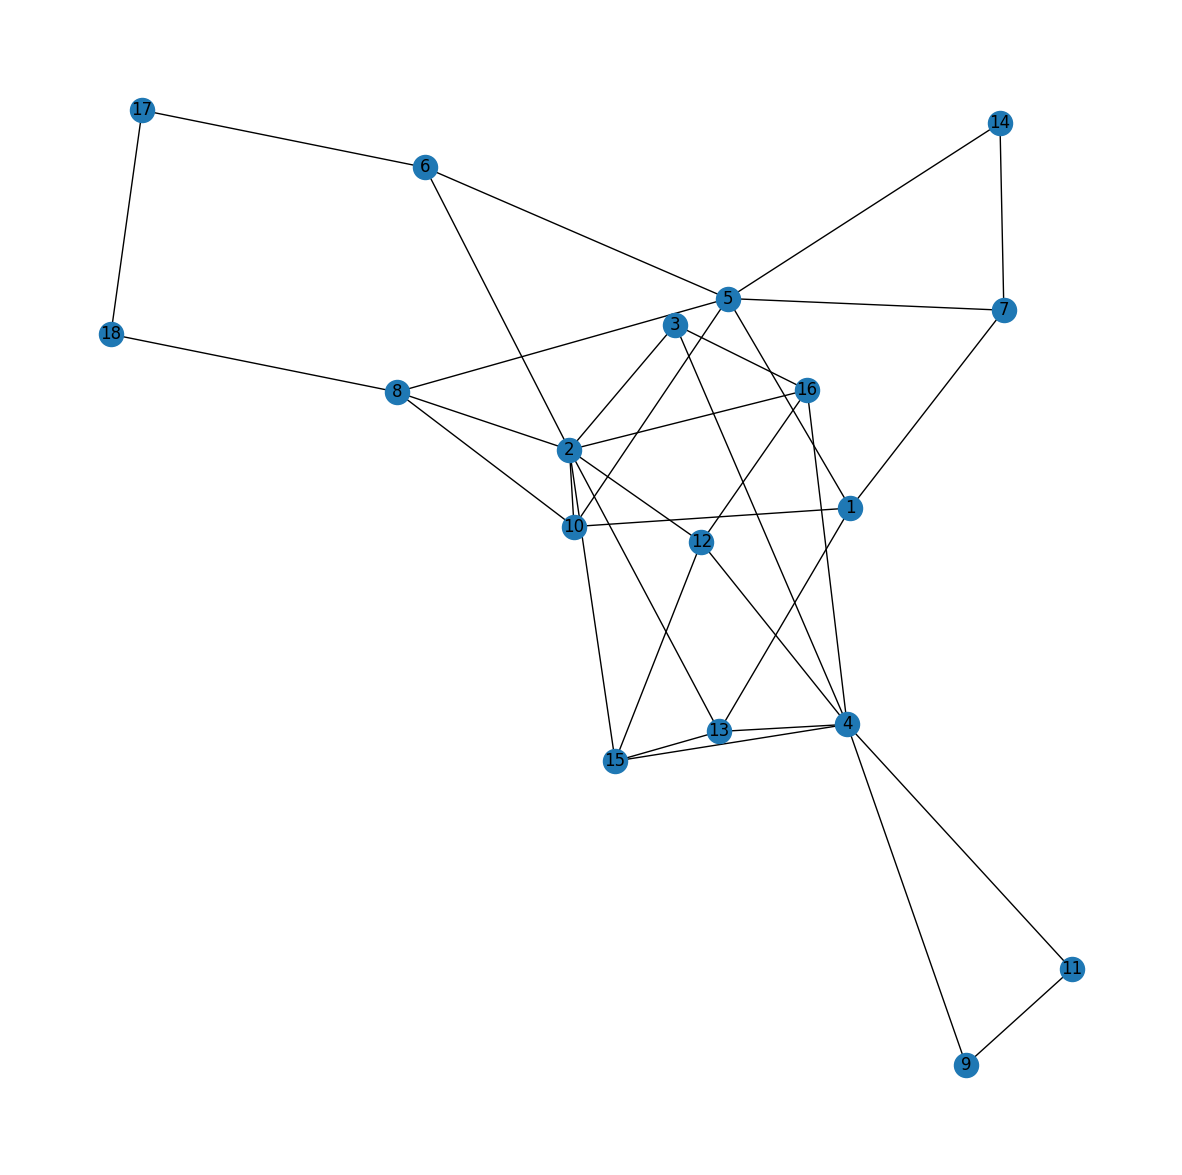

In [220]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos)

plt.axis("off")
plt.savefig("default.png")
plt.show() 

In [20]:
# pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(2000, 3)))
# o3d.visualization.draw_geometries([pcd])
# o3d.visualization.draw_geometries([octree])

In [46]:
# 指定した点のボクセルを取得する関数
def find_voxel_for_point(octree, point):
    result = octree.locate_leaf_node(point)
    if result is not None:
        node, _ = result
        return node
    else:
        return None

# ノードの中心座標を取得する関数
def get_voxel_center(node, min_bound, voxel_size):
    center = min_bound + (np.asarray(node.origin) + voxel_size / 2.0)
    return center

# 近傍のボクセルを取得する関数
def find_neighbor_voxels(octree, node, min_bound, voxel_size):
    center = get_voxel_center(node, min_bound, voxel_size)
    neighbors = []
    directions = [
        np.array([1, 0, 0]), np.array([-1, 0, 0]),
        np.array([0, 1, 0]), np.array([0, -1, 0]),
        np.array([0, 0, 1]), np.array([0, 0, -1])
    ]
    
    for direction in directions:
        neighbor_center = center + direction * voxel_size
        result = octree.locate_leaf_node(neighbor_center)
        if result is not None:
            neighbor_node, _ = result
            neighbors.append(neighbor_node)
    
    return neighbors


point = pcd.points[0]
voxel = find_voxel_for_point(octree, point)

if voxel is not None:
    min_bound = pcd.get_min_bound()
    max_bound = pcd.get_max_bound()
    voxel_size = (max_bound - min_bound) / (2 ** octree.max_depth)
    
    neighbors = find_neighbor_voxels(octree, voxel, min_bound, voxel_size)
    print(f"Neighbors of the voxel containing {point}:")
    for neighbor in neighbors:
        print(get_voxel_center(neighbor, min_bound, voxel_size))
else:
    print(f"Point {point} is not in any voxel")

AttributeError: 'open3d.cuda.pybind.geometry.OctreePointColorLeafNo' object has no attribute 'origin'

In [61]:
point = pcd.points[0]
voxel = find_voxel_for_point(octree, point)
min_bound = pcd.get_min_bound()
max_bound = pcd.get_max_bound()
voxel_size = (max_bound - min_bound) / (2 ** octree.max_depth)

center = get_voxel_center(voxel, min_bound, voxel_size)

In [118]:
# voxel 内の点をすべて抽出
point = pcd.points[100]
node, node_info = octree.locate_leaf_node(point)
node_points = np.asarray(pcd.points)[node.indices]

neighbors = []
directions = [
    np.array([1, 0, 0]), np.array([-1, 0, 0]),
    np.array([0, 1, 0]), np.array([0, -1, 0]),
    np.array([0, 0, 1]), np.array([0, 0, -1])
]

for direction in directions:
    neighbor_center = node_info.origin + direction * node_info.size
    result = octree.locate_leaf_node(neighbor_center)
    if result is not None:
        neighbor_node, _ = result
        neighbors.append(neighbor_node)

print(neighbors)

[OctreePointColorLeafNode with color [0.211765, 0.219608, 0.2] containing 213 points., None, OctreePointColorLeafNode with color [0.133333, 0.129412, 0.113725] containing 302 points., OctreePointColorLeafNode with color [0.227451, 0.223529, 0.196078] containing 63 points., None, None]


In [119]:
octree

Octree with origin: [-50.4262, -8.83706, -1.76366], size: 1.01, max_depth: 5